# Problem 1 - Variational Auto-Encoder (VAE)

Variational Auto-Encoders (VAEs) are a widely used class of generative models. They are simple to implement and, in contrast to other generative model classes like Generative Adversarial Networks (GANs, see Problem 2), they optimize an explicit maximum likelihood objective to train the model. Finally, their architecture makes them well-suited for unsupervised representation learning, i.e., learning low-dimensional representations of high-dimenionsal inputs, like images, with only self-supervised objectives (data reconstruction in the case of VAEs).

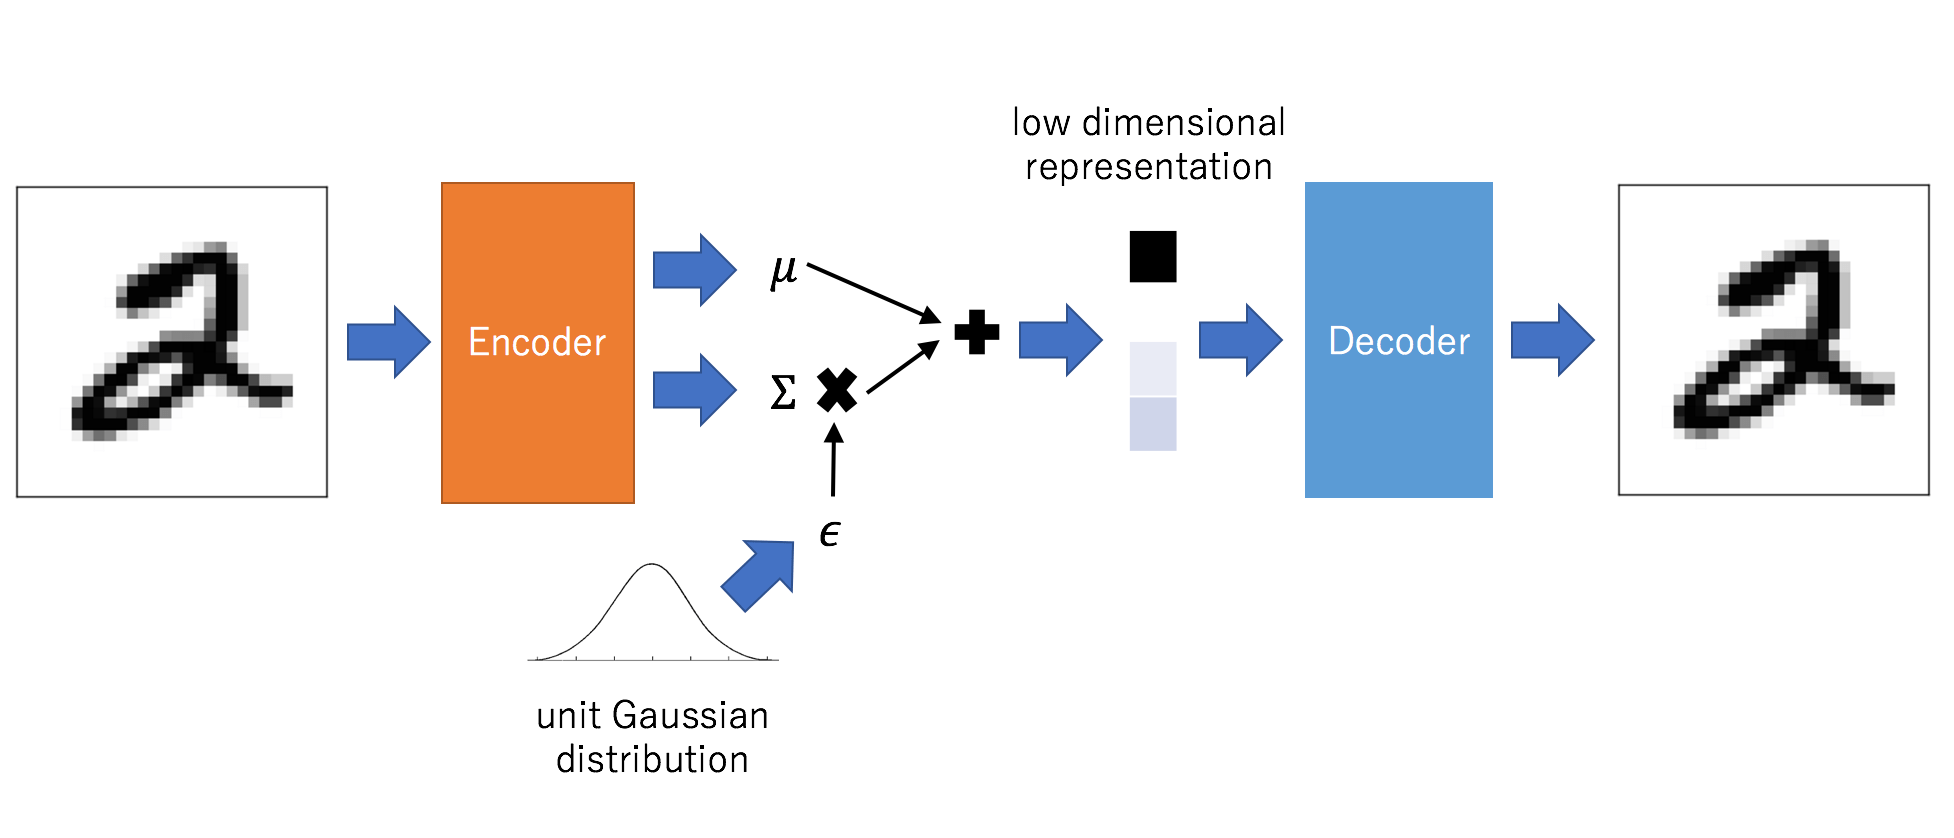
*(image source: https://mlexplained.com/2017/12/28/an-intuitive-explanation-of-variational-autoencoders-vaes-part-1)*

**By working on this problem you will learn and practice the following steps:**
1. Set up a data loading pipeline in PyTorch.
2. Implement, train and visualize an auto-encoder architecture.
3. Extend your implementation to a variational auto-encoder.
4. Learn how to tune the critical beta parameter of your VAE.
5. Inspect the learned representation of your VAE.
6. Extend VAE's generative capabilities by conditioning it on the label you wish to generate.


**Note**: For faster training of the models in this assignment you can enable GPU support in this Colab. Navigate to "Runtime" --> "Change Runtime Type" and set the "Hardware Accelerator" to "GPU". However, you might hit compute limits of the colab free edition. Hence, you might want to debug locally (e.g. in a jupyter notebook) or in a CPU-only runtime on colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. MNIST Dataset

We will perform all experiments for this problem using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a standard dataset of handwritten digits. The main benefits of this dataset are that it is small and relatively easy to model. It therefore allows for quick experimentation and serves as initial test bed in many papers.

Another benefit is that it is so widely used that PyTorch even provides functionality to automatically download it.

Let's start by downloading the data and visualizing some samples.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
print(f"Using device: {device}")

# this will automatically download the MNIST training set
mnist_train = torchvision.datasets.MNIST(root='./data', 
                                         train=True, 
                                         download=True, 
                                         transform=torchvision.transforms.ToTensor())
print("\n Download complete! Downloaded {} training examples!".format(len(mnist_train)))

Using device: cuda:0


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


 Download complete! Downloaded 60000 training examples!


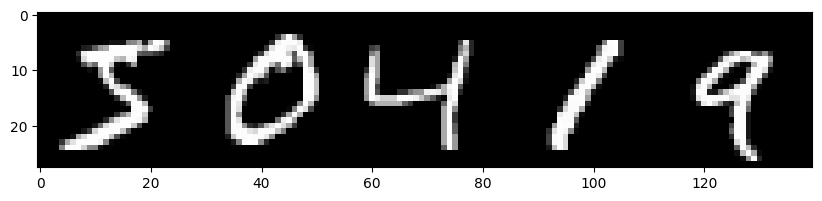

In [3]:
from numpy.random.mtrand import sample
import matplotlib.pyplot as plt
import numpy as np

# Let's display some of the training samples.
sample_images = []
randomize = False # set to False for debugging
num_samples = 5 # simple data sampling for now, later we will use proper DataLoader
if randomize:
  sample_idxs = np.random.randint(low=0,high=len(mnist_train), size=num_samples)
else:
  sample_idxs = list(range(num_samples))

for idx in sample_idxs:
  sample = mnist_train[idx]
  # print(f"Tensor w/ shape {sample[0][0].detach().cpu().numpy().shape} and label {sample[1]}")
  sample_images.append(sample[0][0].data.cpu().numpy())
  # print(sample_images[0]) # Values are in [0, 1]

fig = plt.figure(figsize = (10, 50))   
ax1 = plt.subplot(111)
ax1.imshow(np.concatenate(sample_images, axis=1), cmap='gray')
plt.show()

# 2. Auto-Encoder

Before implementing the full VAE, we will first implement an **auto-encoder architecture**. Auto-encoders feature the same encoder-decoder architecture as VAEs and therefore also learn a low-dimensional representation of the input data without supervision. In contrast to VAEs they are **fully deterministic** models and do not employ variational inference for optimization.

The **architecture** is very simple: we will encode the input image into a low-dimensional representation using fully connected layers for the encoder. This results in a low-dimensional representation of the input image. This representation will get decoded back into the dimensionality of the input image using a decoder network that mirrors the architecture of the encoder. The whole model is trained by **minimizing a reconstruction loss** between the input and the decoded image.

Intuitively, the **auto-encoder needs to compress the information contained in the input image** into a much lower dimensional representation (e.g. 28x28=784px vs. nz embedding dimensions for our MNIST model). This is possible since the information captured in the pixels is *highly redundant*. E.g. encoding an MNIST image requires <4 bits to encode which of the 10 possible digits is displayed and a few additional bits to capture information about shape and orientation. This is much less than the $255^{28\cdot 28}$ bits of information that could be theoretically captured in the input image.

Learning such a **compressed representation can make downstream task learning easier**. For example, learning to add two numbers based on the inferred digits is much easier than performing the task based on two piles of pixel values that depict the digits.

In the following, we will first define the architecture of encoder and decoder and then train the auto-encoder model.

## Defining the Auto-Encoder Architecture [6pt]

In [4]:
import torch.nn as nn

# Prob1-1: Let's define encoder and decoder networks
class Encoder(nn.Module):
  def __init__(self, nz, input_size):
    super().__init__()
    self.input_size = input_size
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Encoder Architecture:                                                        #
    # - input_size -> 256                                                          #
    # - ReLU                                                                       #
    # - 256 -> 64                                                                  #
    # - ReLU                                                                       #
    # - 64 -> nz                                                                   #
    # HINT: Verify the shapes of intermediate layers by running partial networks   #
    #        (with the next notebook cell) and visualizing the output shapes.      #
    ################################################################################
    self.net = nn.Sequential(
            nn.Linear(self.input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, nz)
        )
    ################################ END TODO #######################################
  
  def forward(self, x):
    return self.net(x)


class Decoder(nn.Module):
  def __init__(self, nz, output_size):
    super().__init__()
    self.output_size = output_size
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Decoder Architecture (mirrors encoder architecture):                         #
    # - nz -> 64                                                                   #
    # - ReLU                                                                       #
    # - 64 -> 256                                                                  #
    # - ReLU                                                                       #
    # - 256 -> output_size                                                         #
    ################################################################################
    self.net = nn.Sequential(
            nn.Linear(nz, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, self.output_size),
            nn.Sigmoid()
        )
    ################################ END TODO #######################################
  
  def forward(self, z):
    return self.net(z).reshape(-1, 1, self.output_size)

## Testing the Auto-Encoder Forward Pass

In [5]:
# To test your encoder/decoder, let's encode/decode some sample images
# first, make a PyTorch DataLoader object to sample data batches
batch_size = 64
nworkers = 2        # number of workers used for efficient data loading

####################################################################################
# Create a PyTorch DataLoader object for efficiently generating training batches.  #
# Make sure that the data loader automatically shuffles the training dataset.      #
# Consider only *full* batches of data, to avoid torch errrors.              #
# The DataLoader wraps the MNIST dataset class we created earlier.           #
#       Use the given batch_size and number of data loading workers when creating  #
#       the DataLoader. https://pytorch.org/docs/stable/data.html                  #
####################################################################################
mnist_data_loader = torch.utils.data.DataLoader(mnist_train, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                num_workers=nworkers,
                                                drop_last=True)
####################################################################################

# now we can run a forward pass for encoder and decoder and check the produced shapes
in_size = out_size = 28*28 # image size
nz = 32          # dimensionality of the learned embedding
encoder = Encoder(nz=nz, input_size=in_size)
decoder = Decoder(nz=nz, output_size=out_size)
for sample_img, sample_label in mnist_data_loader: # loads a batch of data
  input = sample_img.reshape([batch_size, in_size])
  print(f'{sample_img.shape=}, {type(sample_img)}, {input.shape=}')
  enc = encoder(input)
  print(f"Shape of encoding vector (should be [batch_size, nz]): {enc.shape}")
  dec = decoder(enc)
  print("Shape of decoded image (should be [batch_size, 1, out_size]): {}.".format(dec.shape))    
  break

del input, enc, dec, encoder, decoder, nworkers # remove to avoid confusion later

sample_img.shape=torch.Size([64, 1, 28, 28]), <class 'torch.Tensor'>, input.shape=torch.Size([64, 784])
Shape of encoding vector (should be [batch_size, nz]): torch.Size([64, 32])
Shape of decoded image (should be [batch_size, 1, out_size]): torch.Size([64, 1, 784]).


Now that we defined encoder and decoder network our architecture is nearly complete. However, before we start training, we can wrap encoder and decoder into an auto-encoder class for easier handling.

In [6]:
class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.encoder = Encoder(nz=nz, input_size=in_size)
    self.decoder = Decoder(nz=nz, output_size=out_size)

  def forward(self, x):
    enc = self.encoder(x)
    return self.decoder(enc)

  def reconstruct(self, x):
    """Only used later for visualization."""
    enc = self.encoder(x)
    flattened = self.decoder(enc)
    image = flattened.reshape(-1, 28, 28)
    return image

## Setting up the Auto-Encoder Training Loop [6pt]
After implementing the network architecture, we can now set up the training loop and run training.

In [7]:
# Prob1-2
import torch.optim as optim
epochs = 10
learning_rate = 1e-3

# build AE model
print(f'Device available {device}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ae_model = AutoEncoder(nz).to(device)    # transfer model to GPU if available
ae_model = ae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer and loss classes. For the loss you can use a loss layer      #
# from the torch.nn package. We recommend binary cross entropy.                    #
# HINT: We will use the Adam optimizer (learning rate given above, otherwise       #
#       default parameters).                                                       #
# NOTE: We could also use alternative losses like MSE and cross entropy, depending #
#       on the assumptions we are making about the output distribution.            #
####################################################################################
optimizer = optim.Adam(ae_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
#################################### END TODO #######################################

train_it = 0
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the auto-encoder model.                     #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the AE, compute the loss, perform the backward pass and    #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  ####################################################################################
  for (data, _) in mnist_data_loader:
    data = data.view(data.size(0), -1).to(device)
    pred = ae_model.forward(data)
    optimizer.zero_grad()
    data = data.reshape([batch_size, 1, in_size])
    rec_loss = criterion(pred, data)
    ae_model.zero_grad()
    rec_loss.backward()
    optimizer.step()
    if train_it % 100 == 0:
      print("It {}: Reconstruction Loss: {}".format(train_it, rec_loss))
    train_it += 1
  #################################### END TODO #####################################

print("Done!")
del epochs, learning_rate, sample_img, train_it, rec_loss #, opt

Device available cuda:0
Run Epoch 0
It 0: Reconstruction Loss: 0.6942805051803589
It 100: Reconstruction Loss: 0.2735268473625183
It 200: Reconstruction Loss: 0.23141448199748993
It 300: Reconstruction Loss: 0.19668859243392944
It 400: Reconstruction Loss: 0.18132174015045166
It 500: Reconstruction Loss: 0.1562107652425766
It 600: Reconstruction Loss: 0.16137710213661194
It 700: Reconstruction Loss: 0.15066438913345337
It 800: Reconstruction Loss: 0.15091247856616974
It 900: Reconstruction Loss: 0.14123693108558655
Run Epoch 1
It 1000: Reconstruction Loss: 0.14700379967689514
It 1100: Reconstruction Loss: 0.13091620802879333
It 1200: Reconstruction Loss: 0.14098303020000458
It 1300: Reconstruction Loss: 0.1282043755054474
It 1400: Reconstruction Loss: 0.13250276446342468
It 1500: Reconstruction Loss: 0.12135341018438339
It 1600: Reconstruction Loss: 0.11565560102462769
It 1700: Reconstruction Loss: 0.1161888912320137
It 1800: Reconstruction Loss: 0.12441540509462357
Run Epoch 2
It 1900

## Verifying reconstructions
Now that we trained the auto-encoder we can visualize some of the reconstructions on the test set to verify that it is converged and did not overfit. **Before continuing, make sure that your auto-encoder is able to reconstruct these samples near-perfectly.**

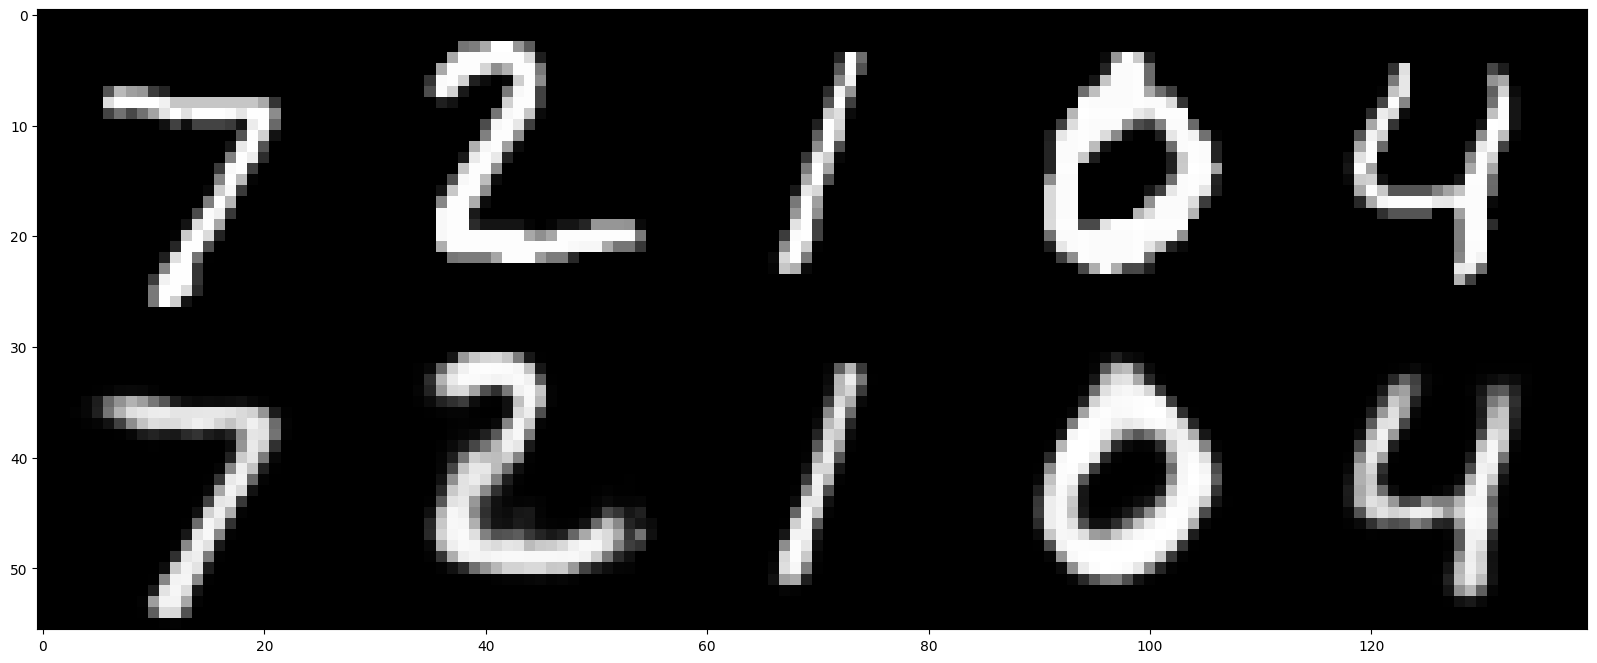

In [8]:
# visualize test data reconstructions
def vis_reconstruction(model, randomize=False):
  # download MNIST test set + build Dataset object
  mnist_test = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          download=True, 
                                          transform=torchvision.transforms.ToTensor())
  model.eval()      # set model in evalidation mode (eg freeze batchnorm params)
  num_samples = 5
  if randomize:
    sample_idxs = np.random.randint(low=0,high=len(mnist_test), size=num_samples)
  else:
    sample_idxs = list(range(num_samples))

  input_imgs, test_reconstructions = [], []
  for idx in sample_idxs:
    sample = mnist_test[idx]
    input_img = np.asarray(sample[0])
    input_flat = input_img.reshape(784)
    reconstruction = model.reconstruct(torch.tensor(input_flat, device=device))
    
    input_imgs.append(input_img[0])
    test_reconstructions.append(reconstruction[0].data.cpu().numpy())
    # print(f'{input_img[0].shape=}\t{reconstruction.shape}')

  fig = plt.figure(figsize = (20, 50))   
  ax1 = plt.subplot(111)
  ax1.imshow(np.concatenate([np.concatenate(input_imgs, axis=1),
                            np.concatenate(test_reconstructions, axis=1)], axis=0), cmap='gray')
  plt.show()

vis_reconstruction(ae_model, randomize=False) # set randomize to False for debugging

## Sampling from the Auto-Encoder [2pt]

To test whether the auto-encoder is useful as a generative model, we can use it like any other generative model: draw embedding samples from a prior distribution and decode them through the decoder network. We will choose a unit Gaussian prior to allow for easy comparison to the VAE later.

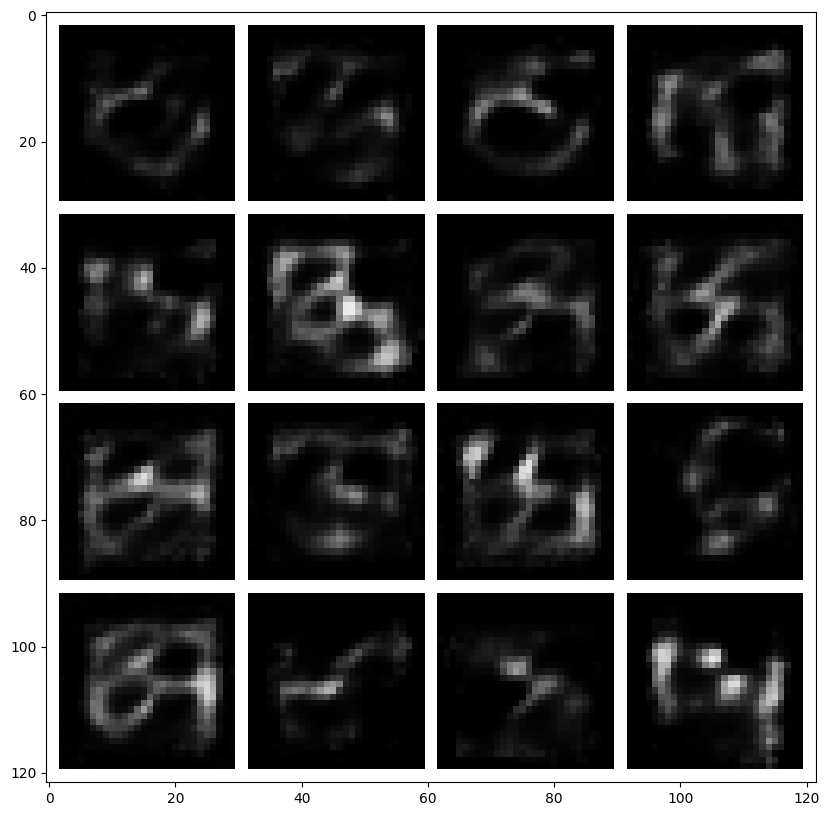

In [9]:
# we will sample N embeddings, then decode and visualize them
def vis_samples(model):
  ####################################### TODO #######################################
  # Prob1-3 Sample embeddings from a diagonal unit Gaussian distribution and decode them     #
  # using the model.                                                                 #
  # HINT: The sampled embeddings should have shape [batch_size, nz]. Diagonal unit   #
  #       Gaussians have mean 0 and a covariance matrix with ones on the diagonal    #
  #       and zeros everywhere else.                                                 #
  # HINT: If you are unsure whether you sampled the correct distribution, you can    #
  #       sample a large batch and compute the empirical mean and variance using the #
  #       .mean() and .var() functions.                                              #
  # HINT: You can directly use model.decoder() to decode the samples.                #
  ####################################################################################
  num_samples = 16  # Number of samples you want to generate

  # Sample embeddings from a diagonal unit Gaussian distribution
  z_samples = torch.randn(num_samples, nz).to(device)

  # Decode the samples using the model's decoder
  decoded_samples = model.decoder(z_samples).detach()

  # Reshape the decoded samples to (num_samples, 1, 28, 28)
  decoded_samples = decoded_samples.view(-1, 1, 28, 28)
  
  #################################### END TODO ######################################

  fig = plt.figure(figsize = (10, 10))   
  ax1 = plt.subplot(111)
  ax1.imshow(torchvision.utils.make_grid(decoded_samples[:16], nrow=4, pad_value=1.)\
                .data.cpu().numpy().transpose(1, 2, 0), cmap='gray')
  plt.show()

vis_samples(ae_model)


>**Prob1-3 continued: Inline Question: Describe your observations, why do you think they occur? [2pt]** 
>(max 150 words)
>
>**Answer:** From the image, you can see some 3's and 8's which are random values to a digit. So we can say that the decoding model has learned the MNIST dataset representations in such a way that it can reconstruct the original image with minimal error from the reduced dimension space. 



# 3. Variational Auto-Encoder (VAE)

Variational auto-encoders use a very similar architecture to deterministic auto-encoders, but are inherently storchastic models, i.e. we perform a stochastic sampling operation during the forward pass, leading to different different outputs every time we run the network for the same input. This sampling is required to optimize the VAE objective also known as the evidence lower bound (ELBO):

$$
p(x) > \underbrace{\mathbb{E}_{z\sim q(z\vert x)} p(x \vert z)}_{\text{reconstruction}} - \underbrace{D_{\text{KL}}\big(q(z \vert x), p(z)\big)}_{\text{prior divergence}}
$$

Here, $D_{\text{KL}}(q, p)$ denotes the Kullback-Leibler (KL) divergence between the posterior distribution $q(z \vert x)$, i.e. the output of our encoder, and $p(z)$, the prior over the embedding variable $z$, which we can choose freely.

For simplicity, we will choose a unit Gaussian prior again. The first term is the reconstruction term we already know from training the auto-encoder. When assuming a Gaussian output distribution for both encoder $q(z \vert x)$ and decoder $p(x \vert z)$ the objective reduces to:

$$
\mathcal{L}_{\text{VAE}} = \sum_{x\sim \mathcal{D}} \mathcal{L}_{\text{rec}}(x, \hat{x}) - \beta \cdot D_{\text{KL}}\big(\mathcal{N}(\mu_q, \sigma_q), \mathcal{N}(0, I)\big)
$$

Here, $\hat{x}$ is the reconstruction output of the decoder. In comparison to the auto-encoder objective, the VAE adds a regularizing term between the output of the encoder and a chosen prior distribution, effectively forcing the encoder output to not stray too far from the prior during training. As a result the decoder gets trained with samples that look pretty similar to samples from the prior, which will hopefully allow us to generate better images when using the VAE as a generative model and actually feeding it samples from the prior (as we have done for the AE before).

The coefficient $\beta$ is a scalar weighting factor that trades off between reconstruction and regularization objective. We will investigate the influence of this factor in out experiments below.

If you need a refresher on VAEs you can check out this tutorial paper: https://arxiv.org/abs/1606.05908

### Reparametrization Trick

The sampling procedure inside the VAE's forward pass for obtaining a sample $z$ from the posterior distribution $q(z \vert x)$, when implemented naively, is non-differentiable. However, since $q(z\vert x)$ is parametrized with a Gaussian function, there is a simple trick to obtain a differentiable sampling operator, known as the _reparametrization trick_.

Instead of directly sampling $z \sim \mathcal{N}(\mu_q, \sigma_q)$ we can "separate" the network's predictions and the random sampling by computing the sample as:

$$
z = \mu_q + \sigma_q * \epsilon , \quad \epsilon \sim \mathcal{N}(0, I)
$$

Note that in this equation, the sample $z$ is computed as a deterministic function of the network's predictions $\mu_q$ and $\sigma_q$ and therefore allows to propagate gradients through the sampling procedure.

**Note**: While in the equations above the encoder network parametrizes the standard deviation $\sigma_q$ of the Gaussian posterior distribution, in practice we usually parametrize the **logarithm of the standard deviation** $\log \sigma_q$ for numerical stability. Before sampling $z$ we will then exponentiate the network's output to obtain $\sigma_q$.



## Defining the VAE Model [7pt]

In [10]:
def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
  """Computes KL[p||q] between two Gaussians defined by [mu, log_sigma]."""
  return (log_sigma2 - log_sigma1) + (torch.exp(log_sigma1) ** 2 + (mu1 - mu2) ** 2) \
               / (2 * torch.exp(log_sigma2) ** 2) - 0.5

# Prob1-4
class VAE(nn.Module):
  def __init__(self, nz, beta=1.0):
    super().__init__()
    self.beta = beta          # factor trading off between two loss components
    ####################################### TODO #######################################
    # Instantiate Encoder and Decoder.                                                 #
    # HINT: Remember that the encoder is now parametrizing a Gaussian distribution's   #
    #       mean and log_sigma, so the dimensionality of the output needs to           #
    #       double. The decoder works with an embedding sampled from this output.  #
    ####################################################################################
    self.encoder = Encoder(2 * nz, in_size)
    self.decoder = Decoder(nz, out_size)
    #################################### END TODO ######################################

  def forward(self, x):
    ####################################### TODO #######################################
    # Implement the forward pass of the VAE.                                           #
    # HINT: Your code should implement the following steps:                            #
    #          1. encode input x, split encoding into mean and log_sigma of Gaussian   #
    #          2. sample z from inferred posterior distribution using                  #
    #             reparametrization trick                                              #
    #          3. decode the sampled z to obtain the reconstructed image               #
    ####################################################################################
    x_flat = x.view(x.size(0), -1)
    encoding = self.encoder(x_flat)

    epsilon = torch.rand_like(torch.log(encoding[:, nz:]))*torch.exp(encoding[:, nz:])  
    z = encoding[:, :nz] + epsilon

    # Decode the sampled z to obtain the reconstructed image
    reconstruction_flat = self.decoder(z)

    # Reshape the reconstructed image to match the original input shape
    reconstruction = reconstruction_flat.view(x.shape)
    #################################### END TODO ######################################

    return {'q': encoding, 
            'rec': reconstruction}

  def loss(self, x, outputs):
    ####################################### TODO #######################################
    # Implement the loss computation of the VAE.                                       #
    # HINT: Your code should implement the following steps:                            #
    #          1. compute the image reconstruction loss, similar to AE loss above      #
    #          2. compute the KL divergence loss between the inferred posterior        #
    #             distribution and a unit Gaussian prior; you can use the provided     #
    #             function above for computing the KL divergence between two Gaussians #
    #             parametrized by mean and log_sigma                                   #
    # HINT: Make sure to compute the KL divergence in the correct order since it is    #
    #       not symmetric!!  ie. KL(p, q) != KL(q, p)                                  #
    ####################################################################################
    rec, q = outputs['rec'], outputs['q']
    rec_loss = criterion(rec, x)
    kl_loss = kl_divergence(q[:, :nz],q[:, nz:], torch.zeros_like(q[:, :nz]), torch.zeros_like(q[:, nz:])).mean()
    #################################### END TODO ######################################

    # return weighted objective
    return rec_loss + self.beta * kl_loss, \
           {'rec_loss': rec_loss, 'kl_loss': kl_loss}
    
  def reconstruct(self, x):
    """Use mean of posterior estimate for visualization reconstruction."""
    ####################################### TODO #######################################
    # This function is used for visualizing reconstructions of our VAE model. To       #
    # obtain the maximum likelihood estimate we bypass the sampling procedure of the   #
    # inferred latent and instead directly use the mean of the inferred posterior.     #
    # HINT: encode the input image and then decode the mean of the posterior to obtain #
    #       the reconstruction.                                                        #
    ####################################################################################
    q = self.encoder(x)
    # Reshape q to have shape [batch_size, nz] before passing to decoder
    q = q.view(-1, 1, nz)
    reconstruction = self.decoder(q)
    image = reconstruction.reshape(-1, 28, 28)
    #################################### END TODO ######################################
    return image


## Setting up the VAE Training Loop [4pt]

Let's start training the VAE model! We will first verify our implementation by setting $\beta = 0$.


Running 5 epochs with beta=0
Run Epoch 0
It 0: Total Loss: 0.6961082816123962, 	 Rec Loss: 0.6961082816123962,	 KL Loss: 0.010319415479898453
It 100: Total Loss: 0.24501650035381317, 	 Rec Loss: 0.24501650035381317,	 KL Loss: 0.8981658220291138
It 200: Total Loss: 0.20014910399913788, 	 Rec Loss: 0.20014910399913788,	 KL Loss: 1.9844939708709717
It 300: Total Loss: 0.17391321063041687, 	 Rec Loss: 0.17391321063041687,	 KL Loss: 3.66562819480896
It 400: Total Loss: 0.17669807374477386, 	 Rec Loss: 0.17669807374477386,	 KL Loss: 4.274234771728516
It 500: Total Loss: 0.14852939546108246, 	 Rec Loss: 0.14852939546108246,	 KL Loss: 5.278689384460449
It 600: Total Loss: 0.15027065575122833, 	 Rec Loss: 0.15027065575122833,	 KL Loss: 7.045208930969238
It 700: Total Loss: 0.14951540529727936, 	 Rec Loss: 0.14951540529727936,	 KL Loss: 6.5409064292907715
It 800: Total Loss: 0.14871126413345337, 	 Rec Loss: 0.14871126413345337,	 KL Loss: 7.995363235473633
It 900: Total Loss: 0.14182814955711365,

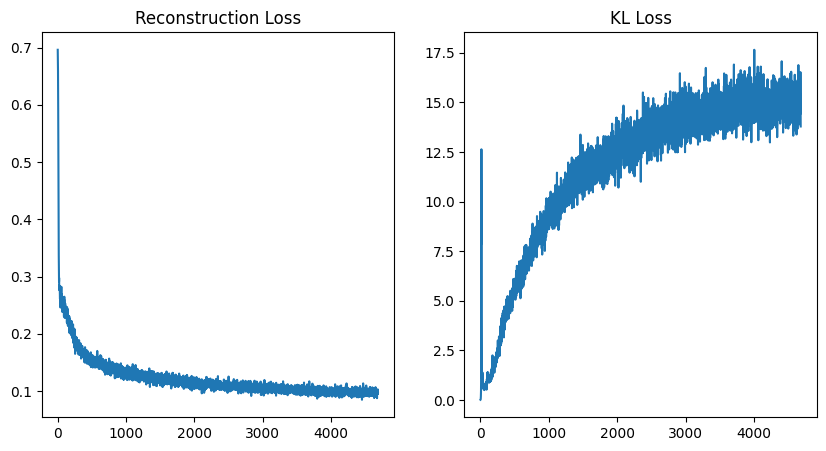

In [11]:
# Prob1-5 VAE training loop
learning_rate = 1e-3
nz = 32
beta = 0

####################################### TODO #######################################
epochs = 5      # recommended 5-20 epochs
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
# same as AE
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the VAE model.                              #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the VAE, compute the loss, perform the backward pass and   #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  # HINT: This time we will use the loss() function of our model for computing the   #
  #       training loss. It outputs the total training loss and a dict containing    #
  #       the breakdown of reconstruction and KL loss.                               #
  ####################################################################################
  for (data, _) in mnist_data_loader:

    data = data.to(device) 
    forward_outs = vae_model.forward(data)
    vae_model.zero_grad()
    optimizer.zero_grad()
    total_loss, losses = vae_model.loss(data, forward_outs)
    total_loss = total_loss.cpu()
    total_loss.backward()
    losses['rec_loss'] = losses['rec_loss'].detach().cpu()
    losses['kl_loss'] = losses['kl_loss'].detach().cpu()
    optimizer.step()

    rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
    if train_it % 100 == 0:
      print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
            .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
    train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

Let's look at some reconstructions and decoded embedding samples!

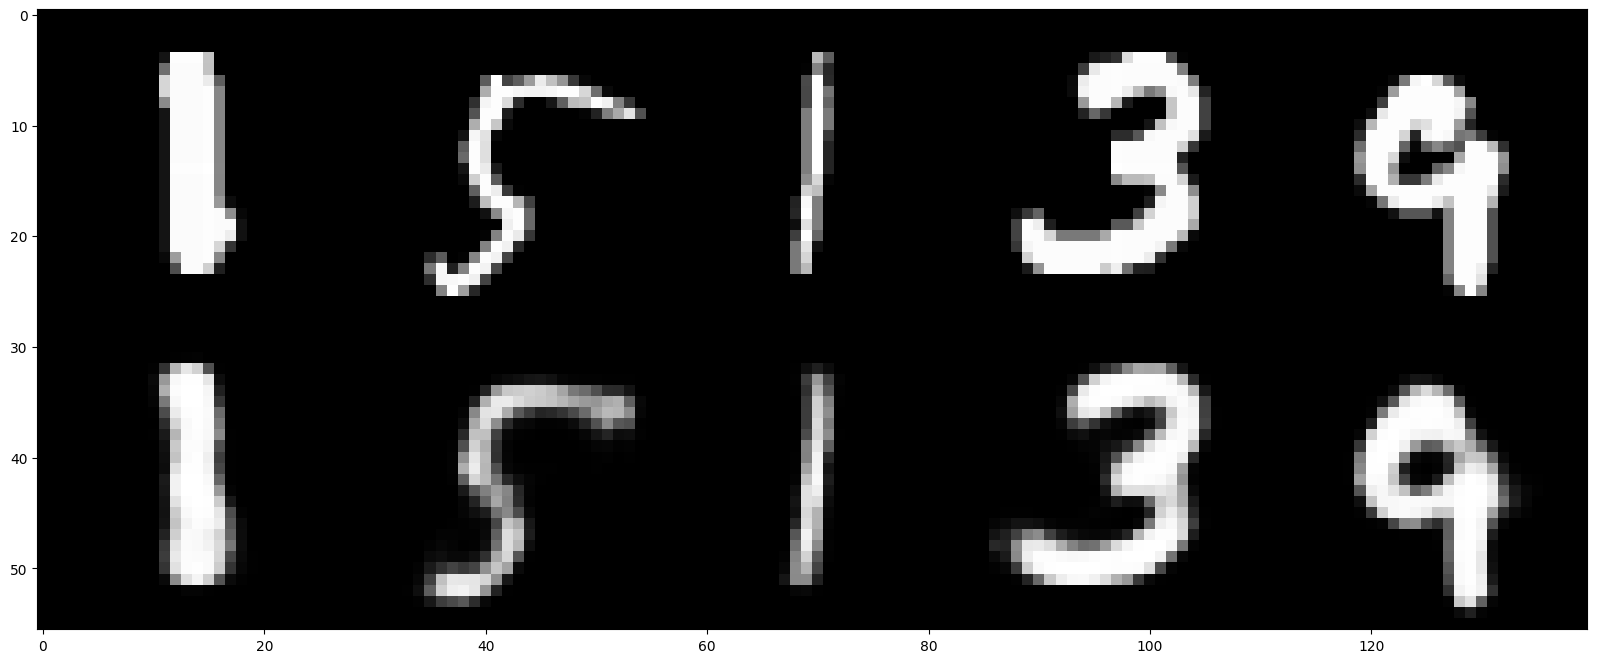

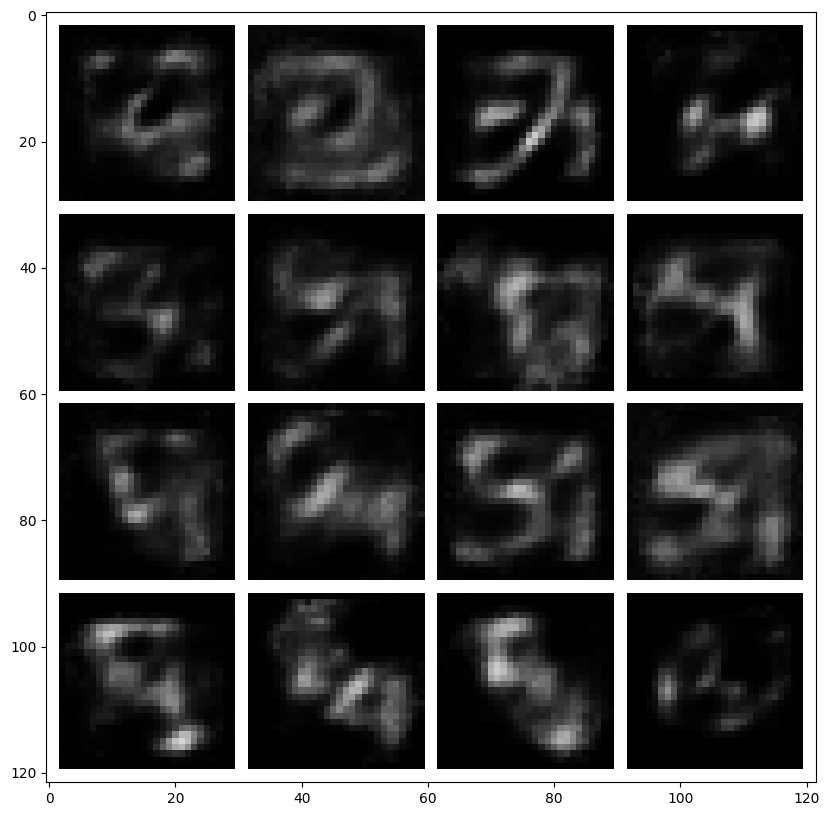

In [12]:
# visualize VAE reconstructions and samples from the generative model
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

## Tweaking the loss function $\beta$ [2pt]
Prob1-6: Let's repeat the same experiment for $\beta = 10$, a very high value for the coefficient.

Running 5 epochs with beta=10
Run Epoch 0
It 0: Total Loss: 0.7774035930633545, 	 Rec Loss: 0.6925439238548279,	 KL Loss: 0.00848596915602684
It 100: Total Loss: 0.2648884654045105, 	 Rec Loss: 0.2640683352947235,	 KL Loss: 8.20136338006705e-05
It 200: Total Loss: 0.26275840401649475, 	 Rec Loss: 0.2619995176792145,	 KL Loss: 7.588835433125496e-05
It 300: Total Loss: 0.2581144869327545, 	 Rec Loss: 0.2574158012866974,	 KL Loss: 6.986992957536131e-05
It 400: Total Loss: 0.24540328979492188, 	 Rec Loss: 0.24486301839351654,	 KL Loss: 5.4027303121984005e-05
It 500: Total Loss: 0.26625555753707886, 	 Rec Loss: 0.26543179154396057,	 KL Loss: 8.237548172473907e-05
It 600: Total Loss: 0.2584978938102722, 	 Rec Loss: 0.2579411566257477,	 KL Loss: 5.5673925089649856e-05
It 700: Total Loss: 0.25720739364624023, 	 Rec Loss: 0.25678303837776184,	 KL Loss: 4.243569856043905e-05
It 800: Total Loss: 0.25965416431427, 	 Rec Loss: 0.2590273320674896,	 KL Loss: 6.268374272622168e-05
It 900: Total Loss: 

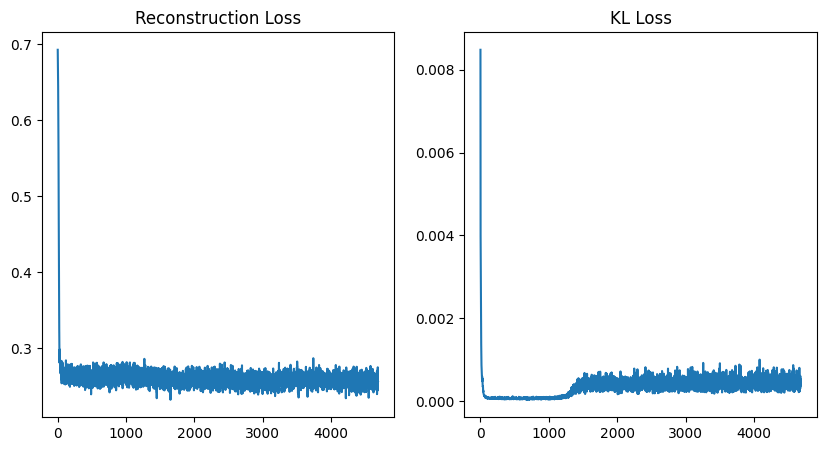

In [13]:
# VAE training loop
learning_rate = 1e-3
nz = 32
beta = 10

####################################### TODO #######################################
epochs = 5      # recommended 5-20 epochs
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
# same as AE
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the VAE model.                              #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the VAE, compute the loss, perform the backward pass and   #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  # HINT: This time we will use the loss() function of our model for computing the   #
  #       training loss. It outputs the total training loss and a dict containing    #
  #       the breakdown of reconstruction and KL loss.                               #
  ####################################################################################
  
  for (data, _) in mnist_data_loader:

    data = data.to(device) 
    forward_outs = vae_model.forward(data)
    vae_model.zero_grad()
    optimizer.zero_grad()
    total_loss, losses = vae_model.loss(data, forward_outs)
    total_loss = total_loss.cpu()
    total_loss.backward()
    losses['rec_loss'] = losses['rec_loss'].detach().cpu()
    losses['kl_loss'] = losses['kl_loss'].detach().cpu()
    optimizer.step()
    
    rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
    
    if train_it % 100 == 0:
      print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
            .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
    train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

>**Inline Question: What can you observe when setting $\beta = 0$ and $\beta = 10$? Explain your observations! [2pt]** 
>(max 200 words) 
>
>**Answer**:  We only use logp(x|z) when B=0 and ignore the prior divergence. The reconstruction error is the only one we use. Image will be without any disentanglement. The constraint over the latent bottleneck becomes more severe  when B=10. This leads to further disentanglement of the image.

## Obtaining the best $\beta$-factor [5pt]
Prob 1-6 continued: Now we can start tuning the beta value to achieve a good result. First describe what a "good result" would look like (focus what you would expect for reconstructions and sample quality). 

>**Inline Question: Characterize what properties you would expect for reconstructions and samples of a well-tuned VAE! [3pt]**
>(max 200 words)
>
>**Answer**: The disentangled representations will be learned by a well-tuned B-VAE, which will also have fewer reconstruction errors. They will nevertheless have reduced interpretability of the latent space.
>

Now that you know what outcome we would like to obtain, try to tune $\beta$ to achieve this result. Logarithmic search in steps of 10x will be helpful, good results can be achieved after ~20 epochs of training. Training reconstructions should be high quality, test samples should be diverse, distinguishable numbers, most samples recognizable as numbers.

**Answer: Tuned beta value ___1e-5____ [2pt]**

In [14]:
# Tuning for best beta
learning_rate = 1e-3
nz = 32

####################################### TODO #######################################
epochs = 10      # recommended 5-20 epochs
betas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000] # Tunex this for best results
#################################### END TODO ######################################

best_beta = None
best_loss = float('inf') 

for beta in betas:

  # build VAE model
  vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
  vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

  # build optimizer and loss function
  ####################################### TODO #######################################
  # Build the optimizer for the vae_model. We will again use the Adam optimizer with #
  # the given learning rate and otherwise default parameters.                        #
  ####################################################################################
  # same as AE
  optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
  loss_f = nn.BCELoss(reduction = 'mean')
  #################################### END TODO ######################################

  train_it = 0
  rec_loss, kl_loss = [], []
  print(f"Running {epochs} epochs with {beta=}")
  for ep in range(epochs):
    print("Run Epoch {}".format(ep))
    ####################################### TODO #######################################
    # Implement the main training loop for the VAE model.                              #
    # HINT: Your training loop should sample batches from the data loader, run the     #
    #       forward pass of the VAE, compute the loss, perform the backward pass and   #
    #       perform one gradient step with the optimizer.                              #
    # HINT: Don't forget to erase old gradients before performing the backward pass.   #
    # HINT: This time we will use the loss() function of our model for computing the   #
    #       training loss. It outputs the total training loss and a dict containing    #
    #       the breakdown of reconstruction and KL loss.                               #
    ####################################################################################
    for image, _ in mnist_data_loader:
      
      data = data.to(device) 
      forward_outs = vae_model.forward(data)
      vae_model.zero_grad()
      optimizer.zero_grad()
      total_loss, losses = vae_model.loss(data, forward_outs)
      total_loss = total_loss.cpu()
      total_loss.backward()
      losses['rec_loss'] = losses['rec_loss'].detach().cpu()
      losses['kl_loss'] = losses['kl_loss'].detach().cpu()
      optimizer.step()

      rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
      if train_it % 100 == 0:
        print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
              .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
      train_it += 1
    #################################### END TODO ####################################
    if total_loss < best_loss:
        best_beta = beta
        best_loss = total_loss

print("Best beta: ", best_beta)
print("Done!")

# rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
# kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
# fig = plt.figure(figsize = (10, 5))   
# ax1 = plt.subplot(121)
# ax1.plot(rec_loss_plotdata)
# ax1.title.set_text("Reconstruction Loss")
# ax2 = plt.subplot(122)
# ax2.plot(kl_loss_plotdata)
# ax2.title.set_text("KL Loss")
# plt.show()

Running 10 epochs with beta=1e-05
Run Epoch 0
It 0: Total Loss: 0.6930288076400757, 	 Rec Loss: 0.6930287480354309,	 KL Loss: 0.008102217689156532
It 100: Total Loss: 0.21614541113376617, 	 Rec Loss: 0.21608348190784454,	 KL Loss: 6.193103313446045
It 200: Total Loss: 0.1357218474149704, 	 Rec Loss: 0.13548865914344788,	 KL Loss: 23.318504333496094
It 300: Total Loss: 0.08387155085802078, 	 Rec Loss: 0.08352910727262497,	 KL Loss: 34.24430847167969
It 400: Total Loss: 0.06658703833818436, 	 Rec Loss: 0.06615865230560303,	 KL Loss: 42.838584899902344
It 500: Total Loss: 0.06164640933275223, 	 Rec Loss: 0.0611923523247242,	 KL Loss: 45.40559387207031
It 600: Total Loss: 0.05971870943903923, 	 Rec Loss: 0.05924711748957634,	 KL Loss: 47.15907287597656
It 700: Total Loss: 0.059082865715026855, 	 Rec Loss: 0.058612942695617676,	 KL Loss: 46.99239730834961
It 800: Total Loss: 0.05862441286444664, 	 Rec Loss: 0.058168478310108185,	 KL Loss: 45.593528747558594
It 900: Total Loss: 0.05844736471

Running 5 epochs with beta=1e-05
Run Epoch 0
It 0: Total Loss: 0.6948392391204834, 	 Rec Loss: 0.6948391795158386,	 KL Loss: 0.00786057859659195
It 100: Total Loss: 0.24694325029850006, 	 Rec Loss: 0.24692822992801666,	 KL Loss: 1.5019521713256836
It 200: Total Loss: 0.215437650680542, 	 Rec Loss: 0.21541805565357208,	 KL Loss: 1.9594446420669556
It 300: Total Loss: 0.16631804406642914, 	 Rec Loss: 0.1662781685590744,	 KL Loss: 3.987130641937256
It 400: Total Loss: 0.15436378121376038, 	 Rec Loss: 0.1543022096157074,	 KL Loss: 6.157610893249512
It 500: Total Loss: 0.15981610119342804, 	 Rec Loss: 0.15973950922489166,	 KL Loss: 7.659670829772949
It 600: Total Loss: 0.13873203098773956, 	 Rec Loss: 0.13864091038703918,	 KL Loss: 9.112015724182129
It 700: Total Loss: 0.14596359431743622, 	 Rec Loss: 0.14587242901325226,	 KL Loss: 9.116905212402344
It 800: Total Loss: 0.13573096692562103, 	 Rec Loss: 0.13563689589500427,	 KL Loss: 9.407159805297852
It 900: Total Loss: 0.12330283969640732, 

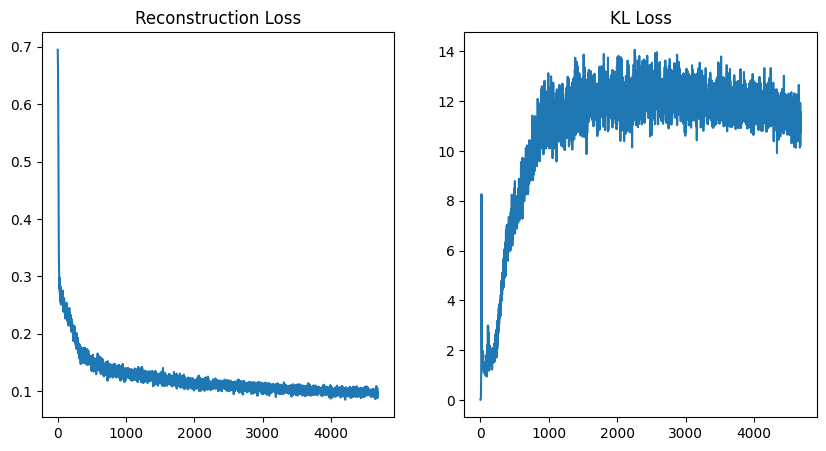

In [15]:
# VAE training loop
learning_rate = 1e-3
nz = 32
beta = best_beta

####################################### TODO #######################################
epochs = 5      # recommended 5-20 epochs
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
# same as AE
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the VAE model.                              #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the VAE, compute the loss, perform the backward pass and   #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  # HINT: This time we will use the loss() function of our model for computing the   #
  #       training loss. It outputs the total training loss and a dict containing    #
  #       the breakdown of reconstruction and KL loss.                               #
  ####################################################################################
  
  for (data, _) in mnist_data_loader:

    data = data.to(device) 
    forward_outs = vae_model.forward(data)
    vae_model.zero_grad()
    optimizer.zero_grad()
    total_loss, losses = vae_model.loss(data, forward_outs)
    total_loss = total_loss.cpu()
    total_loss.backward()
    losses['rec_loss'] = losses['rec_loss'].detach().cpu()
    losses['kl_loss'] = losses['kl_loss'].detach().cpu()
    optimizer.step()
    
    rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
    
    if train_it % 100 == 0:
      print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
            .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
    train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

# 4. Embedding Space Interpolation [3pt]

As mentioned in the introduction, AEs and VAEs cannot only be used to generate images, but also to learn low-dimensional representations of their inputs. In this final section we will investigate the representations we learned with both models by **interpolating in embedding space** between different images. We will encode two images into their low-dimensional embedding representations, then interpolate these embeddings and reconstruct the result.

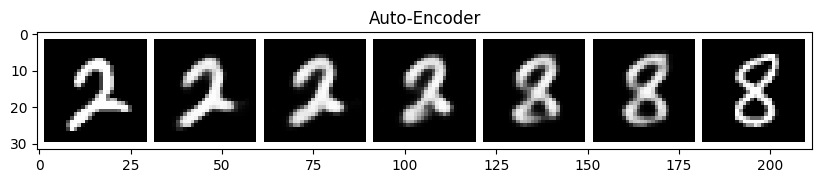

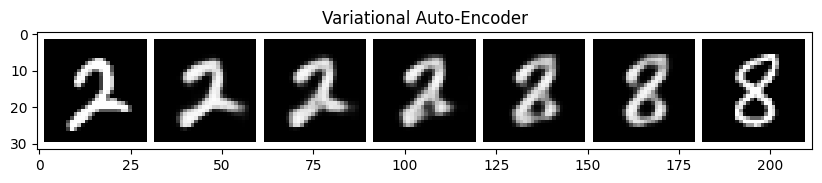

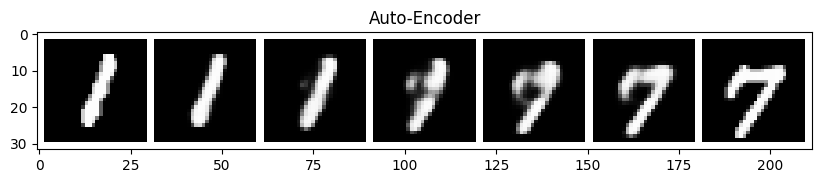

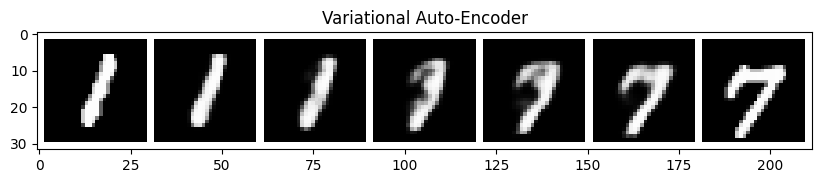

In [16]:
# Prob1-7
nz=32

def get_image_with_label(target_label):
  """Returns a random image from the training set with the requested digit."""
  for img_batch, label_batch in mnist_data_loader:
    for img, label in zip(img_batch, label_batch):
      if label == target_label:
        return img.to(device)

def interpolate_and_visualize(model, tag, start_img, end_img):
  """Encodes images and performs interpolation. Displays decodings."""
  model.eval()    # put model in eval mode to avoid updating batchnorm

  # encode both images into embeddings (use posterior mean for interpolation)
  z_start = model.encoder(start_img[None].reshape(1,784))[..., :nz]
  z_end = model.encoder(end_img[None].reshape(1,784))[..., :nz]

  # compute interpolated latents
  N_INTER_STEPS = 5
  z_inter = [z_start + i/N_INTER_STEPS * (z_end - z_start) for i in range(N_INTER_STEPS)]

  # decode interpolated embeddings (as a single batch)
  img_inter = model.decoder(torch.cat(z_inter))
  img_inter = img_inter.reshape(-1, 28, 28)

  # reshape result and display interpolation
  vis_imgs = torch.cat([start_img, img_inter, end_img]).reshape(-1,1,28,28)
  fig = plt.figure(figsize = (10, 10))   
  ax1 = plt.subplot(111)
  ax1.imshow(torchvision.utils.make_grid(vis_imgs, nrow=N_INTER_STEPS+2, pad_value=1.)\
                  .data.cpu().numpy().transpose(1, 2, 0), cmap='gray')
  plt.title(tag)
  plt.show()


### Interpolation 1
START_LABEL = 2# ... TODO CHOOSE
END_LABEL = 8# ... TODO CHOOSE
# sample two training images with given labels
start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)
# visualize interpolations for AE and VAE models
interpolate_and_visualize(ae_model, "Auto-Encoder", start_img, end_img)
interpolate_and_visualize(vae_model, "Variational Auto-Encoder", start_img, end_img)

### Interpolation 2
START_LABEL = 1# ... TODO CHOOSE
END_LABEL = 7# ... TODO CHOOSE
# sample two training images with given labels
start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)
# visualize interpolations for AE and VAE models
interpolate_and_visualize(ae_model, "Auto-Encoder", start_img, end_img)
interpolate_and_visualize(vae_model, "Variational Auto-Encoder", start_img, end_img)


Repeat the experiment for different start / end labels and different samples. Describe your observations.

>**Prob1-7 continued: Inline Question: Repeat the interpolation experiment with different start / end labels and multiple samples. Describe your observations! [2 pt]**
>  1. How do AE and VAE embedding space interpolations differ?
>  2. How do you expect these differences to affect the usefulness of the learned representation for downstream learning?
>(max 300 words)
>
>**Answer**: 1. In an AE, the latent space where the encoder encodes the input may not be continuous, preventing easy interpolation. VAE latent spaces, on the other hand, are continuous and allow for random sampling.
2. By feeding random values to the decoder part, VAE can generate new data because it learns the mean and variance of the inputs in the latent space. The VAE can produce an image that is more similar to a digit than the autoencoder because it has learned a distribution of potential latent inputs that could result in the particular digit. The AE will make every effort to produce an image that resembles a digit.
>

# 5. Conditional VAE
Let us now try a Conditional VAE
Now we will try to create a [Conditional VAE](https://proceedings.neurips.cc/paper/2014/file/d523773c6b194f37b938d340d5d02232-Paper.pdf), where we can condition the encoder and decoder of the VAE on the label `c`. 

## Defining the conditional Encoder, Decoder, and VAE models [5 pt]

Prob1-8. We create a separate encoder and decoder class that take in an additional argument `c` in their forward pass, and then build our CVAE model on top of it. Note that the encoder and decoder just need to append `c` to the standard inputs to these modules.

In [48]:
def idx2onehot(idx, n):
    """Converts a batch of indices to a one-hot representation."""
    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)

    return onehot

# Let's define encoder and decoder networks
import torch.nn.functional as F
class CVAEEncoder(nn.Module):
  def __init__(self, nz, input_size, conditional, num_labels):
    super().__init__()
    self.input_size = input_size + num_labels if conditional else input_size
    self.num_labels = num_labels
    self.conditional = conditional

    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Encoder Architecture:                                                        #
    # - input_size -> 256                                                          #
    # - ReLU                                                                       #
    # - 256 -> 64                                                                  #
    # - ReLU                                                                       #
    # - 64 -> nz                                                                   #
    # HINT: Verify the shapes of intermediate layers by running partial networks   #
    #        (with the next notebook cell) and visualizing the output shapes.      #
    ################################################################################
    self.net = nn.Sequential(
            nn.Linear(self.input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, nz)
        )
    ################################ END TODO ######################################

  def forward(self, x, c=None):
    ################################# TODO #########################################
    # If using conditional VAE, concatenate x and a onehot version of c to create  #
    # the full input. Use function idx2onehot above.                               #
    ################################################################################
    if self.conditional:
            c_onehot = idx2onehot(c, self.num_labels)
            x = torch.cat((x, c_onehot), dim=-1)
    ################################################################################
    return self.net(x)


class CVAEDecoder(nn.Module):
  def __init__(self, nz, output_size, conditional, num_labels):
    super().__init__()
    self.output_size = output_size
    self.conditional = conditional
    self.num_labels = num_labels
    if self.conditional:
        nz = nz + num_labels
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Decoder Architecture (mirrors encoder architecture):                         #
    # - nz -> 64                                                                   #
    # - ReLU                                                                       #
    # - 64 -> 256                                                                  #
    # - ReLU                                                                       #
    # - 256 -> output_size                                                         #
    ################################################################################
    self.net = nn.Sequential(
            nn.Linear(nz, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
            nn.Sigmoid()
        )
    ################################ END TODO #######################################

  def forward(self, z, c=None):
    ################################# TODO #########################################
    # If using conditional VAE, concatenate z and a onehot version of c to create  #
    # the full embedding. Use function idx2onehot above.                           #
    ################################################################################
    if self.conditional:
      c_onehot = idx2onehot(c, self.num_labels)
      z = torch.cat((z, c_onehot), dim=-1)
  ################################ END TODO #######################################
    return self.net(z).reshape(-1, 1, self.output_size)


class CVAE(nn.Module):
    def __init__(self, nz, beta=1.0, conditional=False, num_labels=0):
        super().__init__()
        if conditional:
            assert num_labels > 0
        self.beta = beta
        self.encoder = CVAEEncoder(2*nz, input_size=in_size, conditional=conditional, num_labels=num_labels)
        self.decoder = CVAEDecoder(nz, output_size=out_size, conditional=conditional, num_labels=num_labels)

    def forward(self, x, c=None):
        if x.dim() > 2:
            x = x.view(-1, 28*28)

        q = self.encoder(x,c)
        mu, log_sigma = torch.chunk(q, 2, dim=-1)

        # sample latent variable z with reparametrization
        eps = torch.normal(mean=torch.zeros_like(mu), std=torch.ones_like(log_sigma))
        
        z = mu + eps * torch.exp(log_sigma)

        # compute reconstruction
        reconstruction = self.decoder(z, c)

        return {'q': q, 'rec': reconstruction, 'c': c}

    def loss(self, x, outputs):
        ####################################### TODO #######################################
        # Implement the loss computation of the VAE.                                       #
        # HINT: Your code should implement the following steps:                            #
        #          1. compute the image reconstruction loss, similar to AE loss above      #
        #          2. compute the KL divergence loss between the inferred posterior        #
        #             distribution and a unit Gaussian prior; you can use the provided     #
        #             function above for computing the KL divergence between two Gaussians #
        #             parametrized by mean and log_sigma                                   #
        # HINT: Make sure to compute the KL divergence in the correct order since it is    #
        #       not symmetric!!  ie. KL(p, q) != KL(q, p)                                  #
        ####################################################################################
        rec_loss = F.mse_loss(outputs['rec'], x.view(x.size(0), 1, 28*28), reduction='sum') / x.size(0)
        mu, log_sigma = torch.chunk(outputs['q'], 2, dim=-1)
        mu2, log_sigma2 = torch.zeros_like(mu), torch.zeros_like(log_sigma)
        kl_loss = kl_divergence(mu, log_sigma, mu2, log_sigma2).sum() / x.size(0)
        #################################### END TODO ######################################

        # return weighted objective
        return rec_loss + self.beta * kl_loss, \
            {'rec_loss': rec_loss, 'kl_loss': kl_loss}
    
    def reconstruct(self, x, c=None):
        """Use mean of posterior estimate for visualization reconstruction."""
        ####################################### TODO #######################################
        # This function is used for visualizing reconstructions of our VAE model. To       #
        # obtain the maximum likelihood estimate we bypass the sampling procedure of the   #
        # inferred latent and instead directly use the mean of the inferred posterior.     #
        # HINT: encode the input image and then decode the mean of the posterior to obtain #
        #       the reconstruction.                                                        #
        ####################################################################################
        if x.dim() > 2:
            x = x.view(-1, 28 * 28)
        q = self.encoder(x, c)
        mu, _ = torch.chunk(q, 2, dim=-1)
        image = self.decoder(mu, c)
        #################################### END TODO ######################################
        return image

## Setting up the CVAE Training loop

Running 8 epochs with beta=1
Run Epoch 0
It 0: Total Loss: 181.59555053710938, 	 Rec Loss: 181.2745361328125,	 KL Loss: 0.32100826501846313
It 100: Total Loss: 52.558128356933594, 	 Rec Loss: 51.89851379394531,	 KL Loss: 0.6596148014068604
It 200: Total Loss: 47.522315979003906, 	 Rec Loss: 46.06696319580078,	 KL Loss: 1.4553524255752563
It 300: Total Loss: 43.954200744628906, 	 Rec Loss: 41.83049011230469,	 KL Loss: 2.1237118244171143
It 400: Total Loss: 47.075870513916016, 	 Rec Loss: 44.66643524169922,	 KL Loss: 2.4094345569610596
It 500: Total Loss: 38.97488021850586, 	 Rec Loss: 35.91660690307617,	 KL Loss: 3.058274269104004
It 600: Total Loss: 38.144683837890625, 	 Rec Loss: 35.00260925292969,	 KL Loss: 3.142072916030884
It 700: Total Loss: 36.78629684448242, 	 Rec Loss: 33.56653594970703,	 KL Loss: 3.219759941101074
It 800: Total Loss: 35.314720153808594, 	 Rec Loss: 31.729772567749023,	 KL Loss: 3.584946632385254
It 900: Total Loss: 37.82763671875, 	 Rec Loss: 34.3292121887207,

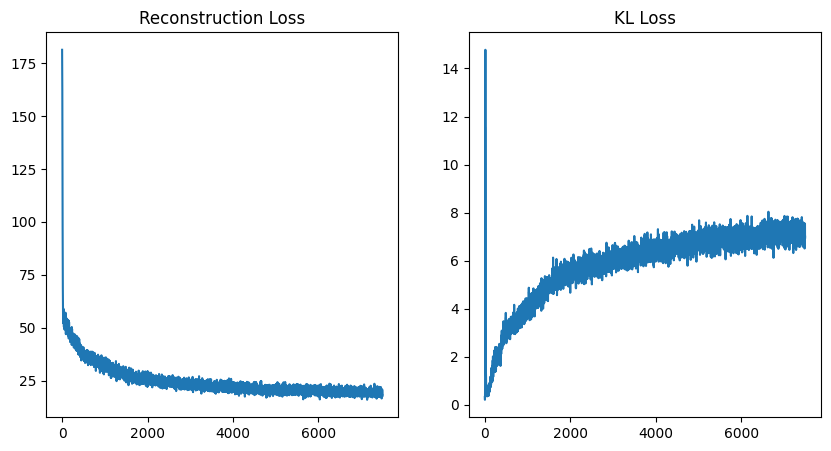

In [68]:

learning_rate = 1e-3
nz = 32

####################################### TODO #######################################
# Tune the beta parameter to obtain good training results. However, for the    #
# initial experiments leave beta = 0 in order to verify our implementation.        #
####################################################################################
epochs = 8# works with fewer epochs than AE, VAE. we only test conditional samples.
beta = 1
#################################### END TODO ######################################

# build CVAE model
conditional = True
cvae_model = CVAE(nz, beta, conditional=conditional, num_labels=10).to(device)    # transfer model to GPU if available
cvae_model = cvae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the cvae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
optimizer = torch.optim.Adam(cvae_model.parameters(), lr=learning_rate)
# same as AE
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print(f"Run Epoch {ep}")
    ####################################### TODO #######################################
    # Implement the main training loop for the model.                                  #
    # If using conditional VAE, remember to pass the conditional variable c to the     #
    # forward pass                                                                     #
    # HINT: Your training loop should sample batches from the data loader, run the     #
    #       forward pass of the model, compute the loss, perform the backward pass and #
    #       perform one gradient step with the optimizer.                              #
    # HINT: Don't forget to erase old gradients before performing the backward pass.   #
    # HINT: As before, we will use the loss() function of our model for computing the  #
    #       training loss. It outputs the total training loss and a dict containing    #
    #       the breakdown of reconstruction and KL loss.                               #
    ####################################################################################
    for (data, labels) in mnist_data_loader:

        data = data.to(device)
        labels = labels.to(device)
        out = cvae_model.forward(data, labels)
        cvae_model.zero_grad()
        optimizer.zero_grad()
        total_loss, losses = cvae_model.loss(data, out)
        total_loss.backward()
        losses['rec_loss'] = losses['rec_loss'].detach().cpu()
        losses['kl_loss'] = losses['kl_loss'].detach().cpu()
        optimizer.step()
        rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
        if train_it % 100 == 0:
            print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
                .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
        train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

### Verifying conditional samples from CVAE [6 pt]
Now let us generate samples from the trained model, conditioned on all the labels.

<Figure size 640x480 with 0 Axes>

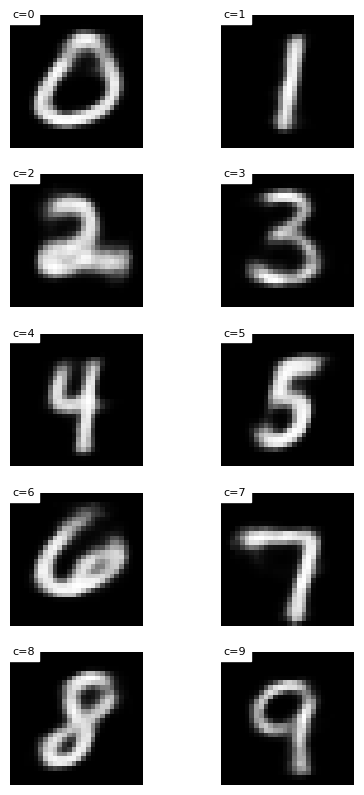

In [69]:
# Prob1-9
if conditional:
    c = torch.arange(0, 10).long().unsqueeze(1).to(device)
    z = torch.randn([10, nz]).to(device)
    x = cvae_model.decoder(z, c=c)
else:
    z = torch.randn([10, nz]).to(device)
    x = cvae_model.decoder(z)

plt.figure()
plt.figure(figsize=(5, 10))
for p in range(10):
    plt.subplot(5, 2, p+1)
    if conditional:
        plt.text(
            0, 0, "c={:d}".format(c[p].item()), color='black',
            backgroundcolor='white', fontsize=8)
    plt.imshow(x[p].view(28, 28).cpu().data.numpy(), cmap='gray')
    plt.axis('off')

# Submission Instructions

You need to submit this jupyter notebook and a PDF. See Piazza for detailed submission instructions.